# SAFECOM Trend Analysis

This notebook provides an example of the trend analysis portion of the Hazard Extraction and Analysis of Trends framework. Trend analysis is applied the the SAFECOM dataset of wildfire aviation mishaps, available here: https://www.safecom.gov/ 

This example uses the trend analysis module from MIKA's knowledge discovery toolkit, as well as the Data utility and SAFECOM utilities. 

Prior to this analysis, hazard extraction is performed using the topic model plus module.

# Imports

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.style
matplotlib.style.use("seaborn")
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import textwrap
import seaborn as sn
sn.color_palette("hls", 17)
import scipy.stats as st
import math
from sklearn.metrics import cohen_kappa_score
import pingouin as pg
plt.rcParams["font.family"] = "Times New Roman"

In [2]:
import sys
import os
sys.path.append(os.path.join("..", "..", "..", ".."))

from mika.kd.trend_analysis import *
from mika.utils import Data
from mika.utils.SAFECOM import *

c:\Users\srandrad\Anaconda3\lib\site-packages\plotly\graph_objs\__init__.py:288: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(ipywidgets.__version__) >= LooseVersion("7.0.0"):
c:\Users\srandrad\Anaconda3\lib\site-packages\plotly\graph_objs\__init__.py:288: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(ipywidgets.__version__) >= LooseVersion("7.0.0"):
c:\Users\srandrad\Anaconda3\lib\site-packages\plotly\graph_objs\__init__.py:288: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(ipywidgets.__version__) >= LooseVersion("7.0.0"):
c:\Users\srandrad\Anaconda3\lib\site-packages\plotly\graph_objs\__init__.py:288: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(ipywidgets.__version__) >= LooseVersion("7.0.0"):
c:\Users\srandrad\Anaconda3\lib\

# SAFECOM Data

Prior to performing HEAT, the SAFECOM dataset needs to be loaded in and cleaned.

The MIKA Data class is used for loading in the preprocessed data. 

Additional cleaning includes:
- identifying event occurrence year
- removing non-fire reports
- correcting regions

In [3]:
list_of_attributes = ['Narrative']
extra_cols = ['Agency', 'Region', 'Location', 'Date', 'Date Submitted', 'Tracking #',
              'Mission Type', 'Persons Onboard', 'Departure Point', 'Destination',
              'Special Use', 'Damages', 'Injuries', 'Hazardous Materials', 'Other Mission Type',
              'Type', 'Manufacturer', 'Model', 'Hazard', 'Incident Management',
              'UAS', 'Accident', 'Airspace', 'Maintenance', 'Mishap Prevention'
              ]
document_id_col = 'Tracking #'

file = os.path.join('topic_model_results','preprocessed_data.csv')
safecom = Data()
safecom.load(file, preprocessed=True, id_col=document_id_col, text_columns=list_of_attributes)
preprocessed_df = safecom.data_df

In [4]:
#extract event occurrence year
preprocessed_df['Year'] = [preprocessed_df.at[i,'Date'].split('/')[-1] for i in range(len(preprocessed_df))]
preprocessed_df['Day'] = [preprocessed_df.at[i,'Date'].split('/')[1] for i in range(len(preprocessed_df))]
preprocessed_df['Month'] = [preprocessed_df.at[i,'Date'].split('/')[0] for i in range(len(preprocessed_df))]

In [5]:
preprocessed_df = preprocessed_df.loc[(preprocessed_df['Year'].astype(int)<2021) & (preprocessed_df['Year'].astype(int)>1994)].reset_index(drop=True)

In [6]:
#remove ids from results file and preprocessed_df if the mission is non-fire
non_fire_missions = [mission for mission in list(preprocessed_df['Mission Type']) if type(mission) is str and 'non-fire' in mission.lower()]
ids_to_drop = preprocessed_df.loc[preprocessed_df['Mission Type'].isin(non_fire_missions)]['Tracking #'].tolist()
preprocessed_df = preprocessed_df.loc[~preprocessed_df['Tracking #'].isin(ids_to_drop)].reset_index(drop=True)
print(len(ids_to_drop))

1983


In [7]:
#correct regions to match corresponding USFS regions
preprocessed_df = correct_regions(preprocessed_df)

In [8]:
preprocessed_df

,Agency,Region,Location,Date,Date Submitted,Tracking #,Mission Type,Persons Onboard,Departure Point,Destination,...,UAS,Accident,Airspace,Maintenance,Mishap Prevention,Raw_Narrative,Year,Day,Month,region_corrected
0,Bureau of Land Management (BLM),Alaska State Office,Fairbanks,05/10/1995,,95-0002,"Fire, Smokejumper",1.0,Fairbanks,,...,,,Intrusion,,,On a practice parachute jump a single engine a...,1995,10,05,Region 10 Alaska Region
1,Bureau of Land Management (BLM),Alaska State Office,Fort Wainwright,05/10/1995,,95-0003,"Fire, Smokejumper",4.0,Birch Hill,,...,,,Intrusion,,,NXXXXX 5-10-95 A small airplane flew thr...,1995,10,05,Region 10 Alaska Region
2,Bureau of Land Management (BLM),Alaska State Office,Fort Wainwright,05/09/1995,,95-0004,"Fire, Air Attack",2.0,Fort Wainwright,,...,,,,Electrical,,"After takeoff from Ft. Wainwight, left generat...",1995,09,05,Region 10 Alaska Region
3,Bureau of Land Management (BLM),California State Office,BFL,07/28/1995,,95-0006,"Fire, Air Attack",2.0,BFL CA.,,...,,,,Hydraulic,,Firewall fitting cracked - leaking hydraulic f...,1995,28,07,Region 05 Pacific Southwest Region
4,Bureau of Land Management (BLM),Alaska State Office,Fire B307,06/14/1995,,95-0009,"Fire, Leadplane",1.0,Fire B307,,...,,,Intrusion,,,While working fire B307 as a lead/air attack w...,1995,14,06,Region 10 Alaska Region
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12546,Fish & Wildlife Service (FWS),R4-Southeast Regional Office,Haines City,11/18/2020,,21-0138,"Fire, Other",0.0,Everglades Headwaters NWR Complex - Hatchineha...,Everglades Headwaters NWR Complex - Hatchineha...,...,"Fleet Operation, Loss of Link, Loss of GPS",,,,,The Parrot Anafi was flying an autonomous mapp...,2020,18,11,Region 08 Southern Area Region
12547,State,California,McClellan Reload Base,12/20/2020,,21-0151,"Fire, Leadplane",0.0,,,...,,,,,,"Prior to pilots' preflight, ATS noticed eviden...",2020,20,12,Region 05 Pacific Southwest Region
12548,State,California,Hemet Airport,12/24/2020,,21-0152,"Fire, Retardant Drop (Airtanker)",1.0,KHMT,KRNM,...,,,,,,While fueling at Ramona AAB after 2.5 hour fue...,2020,24,12,Region 05 Pacific Southwest Region
12549,State,California,Camp Pendleton,12/24/2020,,21-0154,"Fire, Water Drop (Helicopter Fixed-Tank)",3.0,KCRQ,Creek Fire Camp Pendleton,...,,,,,,While engaged in a water dropping mission HT-7...,2020,24,12,Region 05 Pacific Southwest Region


# Hazard Extraction and Primary Analysis

First hazards are identified in documents using LDA topic modeling results and a hazard interptretation spreed sheet created from the topics. 

The hazard file and LDA results file are specified here:

In [9]:
hazard_file = os.path.join('topic_model_results', 'hazard_interpretation_SAFECOM_Final.xlsx')
results_file = os.path.join('topic_model_results','lda_results.xlsx')

Next, the hazard and results file are passed into the identify_docs_per_hazard function, which returns the frequency and documents associated with each hazard in addition to the hazard words and topics per each document:

In [10]:
frequency, docs, hazard_words_per_doc, topics_per_doc, hazard_topics_per_doc = identify_docs_per_hazard(hazard_file, preprocessed_df, results_file, 'Narrative', 'Year', "Tracking #", 'Narrative', doc_topic_dist_field='document topic distribution', topic_thresh=0.0)#,  ids_to_drop= ids_to_drop)

100%|██████████| 28/28 [02:07<00:00,  4.56s/it]


Now drop any unwanted hazards, such as those that are ill-defined or irrelevant to the analysis. The docs variable containing the documents for each hazard is also updated to reflect the removed hazards.

In [11]:
hazards_to_drop = ['Runway Hazards', 'Runway Collisions', 'Refuel Truck Problems']
hazards = [hazard for hazard in frequency if hazard not in hazards_to_drop]
docs = {hazard:docs[hazard] for hazard in hazards}

Then a severity fucntion is defined to calculate hazard severity. We define severity in this case using the function below:

In [12]:
def safecom_severity(passengers, injury, damage):
    key_dict = {"No":0, "Yes":1}
    if passengers == '':
        passengers = 0
    severity = float(passengers)*(key_dict[injury] + key_dict[damage])
    if np.isnan(severity):
        severity=0
    return severity

Severity is calculated for each document using the defined function:

In [13]:
preprocessed_df['severity'] = [safecom_severity(preprocessed_df.iloc[i]['Persons Onboard'], preprocessed_df.iloc[i]['Injuries'], preprocessed_df.iloc[i]['Damages']) for i in range(len(preprocessed_df))]

Now we create the primary results table. The category and subcategory for each hazard is identified from the documents using the get_categories_from_docs function. Finally, the table is created using the create_table function.

In [14]:
categories, sub_categories = get_categories_from_docs(docs, preprocessed_df, "Tracking #")
categories = categories.values()
subcategories = sub_categories.values()
table, severities, rates = create_table(docs, frequency, preprocessed_df, "Tracking #", categories, subcategories, hazards, 'Year')

For display purposes, the table is re-indexed by hazard category and subcategory:

In [15]:
table = table.sort_values(['Category', 'Subcategory'], axis=0).reset_index(drop=True)
df = table[['Category', 'Subcategory']]
ind = pd.MultiIndex.from_frame(df)
table.index = ind
table = table.drop(['Category', 'Subcategory'], axis=1)

The resulting primary results table:

In [16]:
table

Hazards  Frequency  \
Category    Subcategory                                                        
Airspace    Intrusion                                   Intrusion        659   
            Intrusion                    Airspace Control Hazards        977   
Hazard      Communications                      Radio Malfunction       1068   
            Communications              Jumper Operations Hazards        320   
            Communications               Communications Breakdown        349   
            Mission Equipment        Helitorch Operations Failure        333   
            Other                                    Door Failure        491   
            Pilot Action                      Bucket Drop Failure       2216   
            Pilot Action                      In-flight Collision        649   
            Pilot Action                    Cargo Letdown Failure        873   
            Policy Deviation                       Inadequate PPE         86   
            Policy Deviation        Personnel Duty Hours Exceeded        167   
            Policy Deviation                 Load Limits Exceeded        117   
            Policy Deviation                              Medivac        137   
            Weather                                Severe Weather        850   
Maintenance Caution Light      On-board Caution Light Illuminates        771   
            Electrical                       Avionics Malfunction       1013   
            Engine                         Tanker Loading Failure        974   
            Engine                             Engine Malfunction       2687   
            Engine                                Oil Malfunction        743   
            Engine                              Structural Damage       1125   
            Fuel                          Fuel System Malfunction        352   
            Hydraulic                        Hydraulic Fluid Leak        399   
            Landing Gear                 Landing Gear Malfunction        458   
            Rotor (Main)                   Control Surface Damage        750   

                                  Rate  Severity  
Category    Subcategory                           
Airspace    Intrusion           25.346     0.008  
            Intrusion           37.577     0.099  
Hazard      Communications      41.077     0.097  
            Communications      12.308     1.381  
            Communications      13.423     0.106  
            Mission Equipment   12.808     0.192  
            Other               18.885     0.466  
            Pilot Action        85.231     0.336  
            Pilot Action        24.962     0.733  
            Pilot Action        33.577     0.273  
            Policy Deviation     3.308     0.360  
            Policy Deviation     6.423     0.084  
            Policy Deviation     4.500     0.137  
            Policy Deviation     5.269     2.029  
            Weather             32.692     0.434  
Maintenance Caution Light       29.654     0.071  
            Electrical          38.962     0.136  
            Engine              37.462     0.185  
            Engine             103.346     0.118  
            Engine              28.577     0.113  
            Engine              43.269     0.510  
            Fuel                13.538     0.068  
            Hydraulic           15.346     0.120  
            Landing Gear        17.615     0.354  
            Rotor (Main)        28.846     0.541

In [17]:
#table.to_csv(os.path.join(os.path.dirname(os.getcwd()), 'results', 'SAFECOM_hazards.csv'))

To evaluate the quality of the hazard extraction, we recommend randomly sampling 1000 documents to manually label as containing or not containing each hazard. This can be done using the sample_for_accuracy function.

In [18]:
#uncomment this code to create a random sample of 1000 documents for manual labeling
#sample_for_accuracy(preprocessed_df, id_col='Tracking #', text_col='Raw_Narrative', hazards=hazards, save_path=os.path.join(os.getcwd(), 'hazard_validation.csv'), num_sample=1000)

The 1000 document set should be split into a validation set and a test set. The validation set can be used to refine the hazard extraction. For example, you can add/remove topics and hazard words from the hazard interpretation spreadsheet based on the validation set. The test set is not used to tune the hazard extraction, and thus serves as a measure of generalizability.

In [19]:
#uncomment this code to split the full labeled dataset into a validation and test set
# val = pd.read_csv('hazard_validation.csv', index_col=0)
# test = val.sample(n=500).reset_index(drop=True)
# val = val[~val['Tracking #'].isin(test['Tracking #'].tolist())].reset_index(drop=True)
# test.to_csv('labeled_hazards_val.csv')
# val.to_csv('labeled_hazards_test.csv')

Classification metrics (f1, recall, precision, and accuracy) are calculated for the test and validation set to evaluate the quality of the hazard extraction.

In [20]:
metrics, true, pred = calc_classification_metrics('labeled_hazards_val.csv', docs_per_hazard=docs, id_col='Tracking #')
_ = examine_hazard_extraction_mismatches(preprocessed_df, true, pred, hazards, hazard_words_per_doc=hazard_words_per_doc, topics_per_doc=topics_per_doc, hazard_topics_per_doc=hazard_topics_per_doc, results_path='topic_model_results', id_col='Tracking #', text_col='Raw_Narrative')
test_metrics, _, _ = calc_classification_metrics('labeled_hazards_test.csv', docs_per_hazard=docs, id_col='Tracking #')
hazards_sorted = table['Hazards'].tolist()
hazard_extraction = pd.concat([metrics,test_metrics],axis=1,keys=['Validation','Test']).reindex(hazards_sorted)

We output the validation and test classification metrics as a table:

In [21]:
hazard_extraction

Validation                            \
                                       Recall Precision     F1 Accuracy   
Intrusion                               0.808     0.875  0.840    0.984   
Airspace Control Hazards                0.370     0.286  0.323    0.916   
Radio Malfunction                       0.562     0.419  0.480    0.922   
Jumper Operations Hazards               0.857     0.353  0.500    0.976   
Communications Breakdown                0.000     0.000  0.000    0.962   
Helitorch Operations Failure            1.000     0.667  0.800    0.990   
Door Failure                            0.818     0.600  0.692    0.984   
Bucket Drop Failure                     0.964     0.355  0.519    0.900   
In-flight Collision                     0.900     0.621  0.735    0.974   
Cargo Letdown Failure                   1.000     0.576  0.731    0.972   
Inadequate PPE                          1.000     0.500  0.667    0.998   
Personnel Duty Hours Exceeded           0.500     0.500  0.500    0.992   
Load Limits Exceeded                    0.750     0.429  0.545    0.990   
Medivac                                 0.875     1.000  0.933    0.998   
Severe Weather                          0.625     0.263  0.370    0.932   
On-board Caution Light Illuminates      0.385     0.769  0.513    0.924   
Avionics Malfunction                    0.526     0.244  0.333    0.920   
Tanker Loading Failure                  0.833     0.455  0.588    0.958   
Engine Malfunction                      0.797     0.630  0.704    0.894   
Oil Malfunction                         1.000     0.550  0.710    0.982   
Structural Damage                       0.895     0.395  0.548    0.944   
Fuel System Malfunction                 0.292     0.583  0.389    0.956   
Hydraulic Fluid Leak                    0.833     0.938  0.882    0.992   
Landing Gear Malfunction                0.786     0.611  0.688    0.980   
Control Surface Damage                  0.625     0.147  0.238    0.936   

                                             Test                            \
                                   Support Recall Precision     F1 Accuracy   
Intrusion                               26  0.636     0.840  0.724    0.968   
Airspace Control Hazards                27  0.364     0.343  0.353    0.912   
Radio Malfunction                       32  0.808     0.467  0.592    0.942   
Jumper Operations Hazards                7  1.000     0.308  0.471    0.982   
Communications Breakdown                 0  0.000     0.000  0.000    0.982   
Helitorch Operations Failure            10  1.000     0.444  0.615    0.990   
Door Failure                            11  0.375     0.316  0.343    0.954   
Bucket Drop Failure                     28  0.862     0.255  0.394    0.846   
In-flight Collision                     20  0.842     0.593  0.696    0.972   
Cargo Letdown Failure                   19  0.591     0.394  0.473    0.942   
Inadequate PPE                           1  0.750     1.000  0.857    0.998   
Personnel Duty Hours Exceeded            4  0.000     0.000  0.000    0.978   
Load Limits Exceeded                     4  0.000     0.000  0.000    0.994   
Medivac                                  8  0.625     0.556  0.588    0.986   
Severe Weather                          16  0.700     0.368  0.483    0.940   
On-board Caution Light Illuminates      52  0.475     0.683  0.560    0.912   
Avionics Malfunction                    19  0.783     0.409  0.537    0.938   
Tanker Loading Failure                  18  0.778     0.500  0.609    0.946   
Engine Malfunction                      79  0.800     0.519  0.629    0.868   
Oil Malfunction                         11  0.724     0.700  0.712    0.966   
Structural Damage                       19  0.640     0.364  0.464    0.926   
Fuel System Malfunction                 24  0.438     0.538  0.483    0.970   
Hydraulic Fluid Leak                    18  0.867     0.867  0.867    0.992   
Landing Gear Malfunction          

In [22]:
#final_table = pd.concat([table, metrics.reindex(hazards_sorted).set_index(table.index), test_metrics.reindex(hazards_sorted).set_index(table.index)], axis=1, keys=['Hazard Metrics', 'Validation','Test'])
#final_table

### Annotator agreement

Since the annotations of the validation/test data was split 75/25% between two annotators, we calculate annotator agreement on a subset of 50 documents.

In [23]:
#interrater agreement
file = os.path.join(os.getcwd(), "interrater_agreement.xlsx")
r1 = pd.read_excel(file, sheet_name='SA')
r1 = r1[r1.columns[3:]]
r2 = pd.read_excel(file, sheet_name='HW')
r2 = r2[r2.columns[3:]]
agreement = {}
for col in r1.columns:
    agreement[col] = cohen_kappa_score(r1[col],r2[col])

c:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:663: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
c:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:663: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
c:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:663: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
c:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:663: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


In [24]:
np.average([float(v) for v in agreement.values() if not np.isnan(v)])

0.5286986152606619

In [25]:
agreement

{'Hydraulic Fluid Leak': 0.6577181208053691,
 'Intrusion': 1.0,
 'Bucket Drop Failure': 0.7287234042553191,
 'Tanker Loading Failure': 0.37037037037037035,
 'Radio Malfunction': 0.0,
 'On-board Caution Light Illuminates': 0.8521739130434782,
 'Inadequate PPE': nan,
 'Avionics Malfunction': -0.02684563758389258,
 'Severe Weather': 1.0,
 'Landing Gear Malfunction': 0.0,
 'In-flight Collision': 0.6577181208053691,
 'Airspace Control Hazards': 0.48484848484848486,
 'Personnel Duty Hours Exceeded': nan,
 'Jumper Operations Hazards': nan,
 'Control Surface Damage': 0.0,
 'Helitorch Operations Failure': 1.0,
 'Engine Malfunction': 0.7301587301587302,
 'Oil Malfunction': 0.6577181208053691,
 'Load Limits Exceeded': nan,
 'Cargo Letdown Failure': 0.48484848484848486,
 'Door Failure': 0.7901234567901234,
 'Medivac': 0.0,
 'Fuel System Malfunction': 0.6577181208053691}

# Graphic Analysis

The graphic analysis includes:
- severity graphs:
    - time series of hazard severity
    - barchart of average hazard severity
- Frequency graphs:
    - time series of hazard frequency
    - time series of hazard rate
- Pie charts:
    - distribution of region accross hazards
    - distribution of aircraft type accross hazards

For readability, we define a subset of nine hazards for the graphic analysis. 

In [26]:
hazards_for_analysis = ['Hydraulic Fluid Leak', 'Intrusion', 'Bucket Drop Failure','Radio Malfunction',
                       'Jumper Operations Hazards', 'Tanker Loading Failure', 'Helitorch Operations Failure',
                       'Cargo Letdown Failure', 'Severe Weather']

The corresponding frequency, docs, severities, rates, and hazard variables are updated according to the hazards of interest:

In [27]:
#update: frequency, docs, severities, rates, hazards
frequency = {hazard: frequency[hazard] for hazard in hazards_for_analysis}
docs = {hazard: docs[hazard] for hazard in hazards_for_analysis}
severities = {hazard: severities[hazard] for hazard in hazards_for_analysis}
rates = {hazard: rates[hazard] for hazard in hazards_for_analysis}
hazards = hazards_for_analysis

To graph the time series, we first define a list of markers and linestyles to use for the hazards:

In [28]:
markers = ['.','.','.', 'v', 'v','v', 'x', 'x', 'x']
line_styles = ['--', ':','-.','--', ':','-.','--', ':','-.']

### Severity Graphs

Here we graph the severity time series using a logarithmic scale:

c:\Users\srandrad\Anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
c:\Users\srandrad\Anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\srandrad\Anaconda3\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\srandrad\Anaconda3\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
c:\Users\srandrad\Anaconda3\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


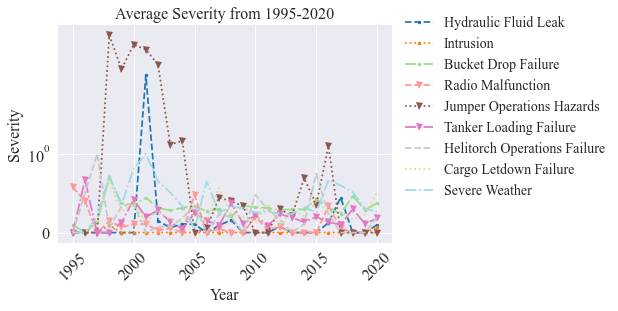

In [29]:
plot_metric_time_series(metric_data=severities, metric_name="Severity", line_styles=line_styles, markers=markers, title="Average Severity from 1995-2020", yscale='log', time_name='Year', show_std=False, save=False)

next, we graph the average severity over the years:

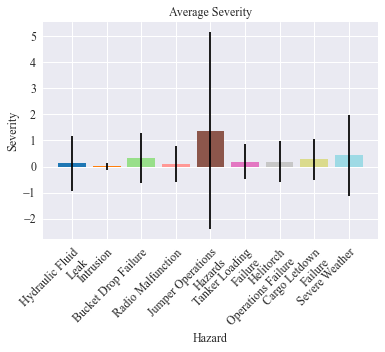

In [30]:
plot_metric_averages(metric_data=severities, metric_name="Severity", show_std=True, title="Average Severity", save=False, legend=False, fontsize=12)

### Frequency Graphs

Now we graph the time series of hazard frequency:

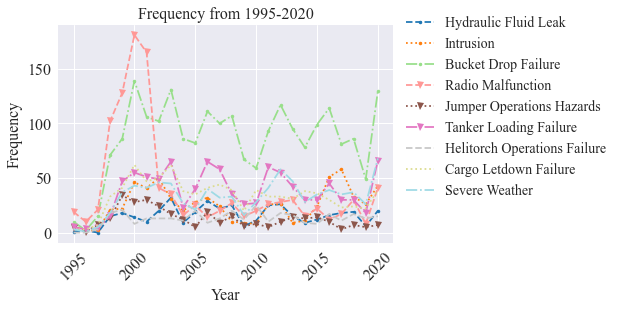

In [31]:
plot_frequency_time_series(frequency, metric_name='Frequency', line_styles=line_styles, markers=markers, title="Frequency from 1995-2020", time_name="Year", scale=False, save=False)

As a comparison, we also graph the rate:

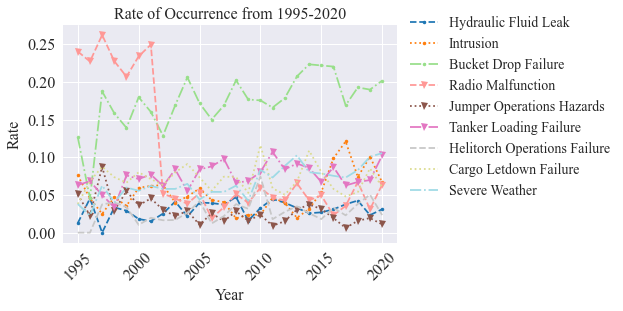

In [32]:
plot_frequency_time_series(rates, metric_name='Rate', line_styles=line_styles, markers=markers, title="Rate of Occurrence from 1995-2020", time_name="Year", scale=False, save=False)

### Pie Charts

pie charts are graphed for the region and aircraft type categorical variables. Other variables of interest could include 'Manufacturer', 'Model', and 'Mission Type'.

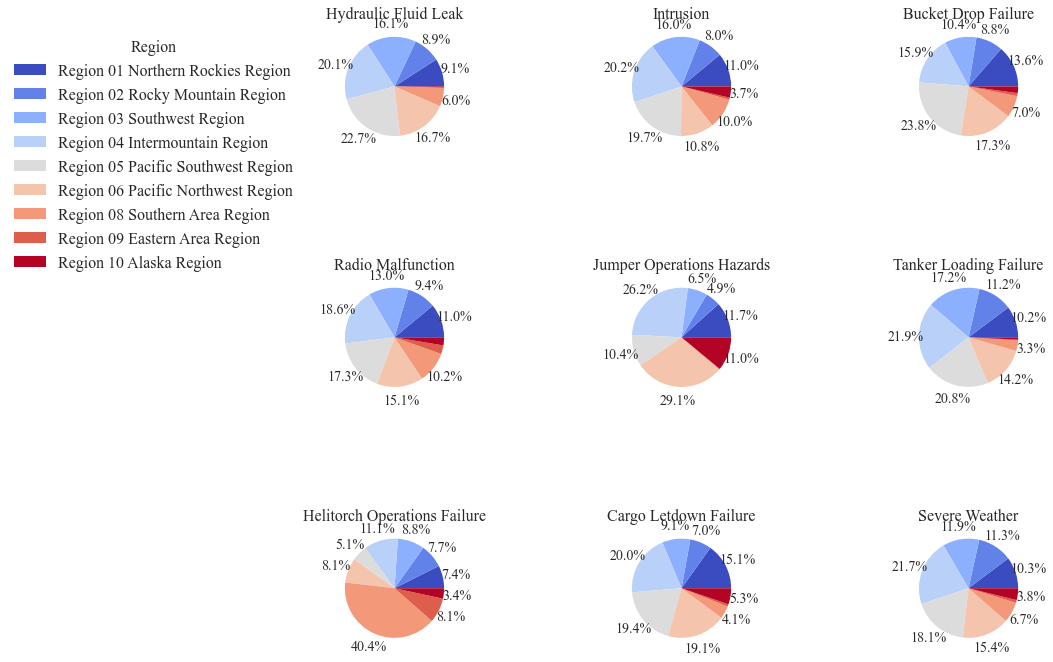

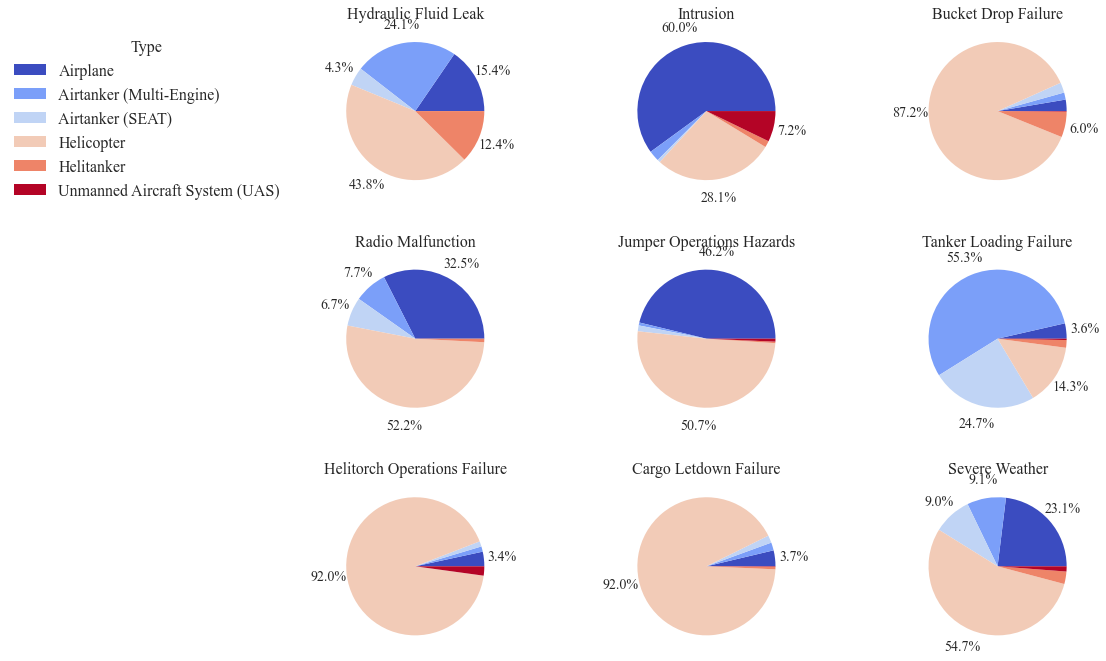

In [33]:
predictors = ['region_corrected', 'Type']
pie_kwargs = {'pctdistance':1.27}
for predictor in predictors:
    if predictor == 'region_corrected': 
        predictor_label='Region'
    else:
        predictor_label = None
    make_pie_chart(docs, preprocessed_df, predictor, hazards, 'Tracking #', predictor_label, save=False, padding=0, pie_kwargs=pie_kwargs)

# Secondary Analysis

The secondary analysis is performed to determine if trends in the graphic analysis are statistically significant. Additionally a risk matrix is produced in this part of the analysis. This step includes:
- chi-squared analysis
- ANOVA 
- Risk matrix

### Chi-Squared Analysis

The chi-squared analysis determines if the distribution of a categorical variable, such as region, is dependent on another variable, such as the presence of a hazard. Essentially this test can determine if a hazard occurs more or less often in a certain categorical variable condition (e.g., a specific region) when compared to the complete dataset. Here we run the chi-squared test for region and aircraft type over each hazard.

To do this, we must first add hazard occurrence to the preprocessed dataframe:

In [34]:
#add hazard values to preprocessed_df
preprocessed_df = add_hazards_to_docs(preprocessed_df, "Tracking #", docs)

Now we run the chi-squared tests, which out put a statistics dataframe and a counts dataframe

In [35]:
pred_dict = {'region_corrected':'Region', 'Type': "Aircraft Type", 'Agency':'Agency'}
stats_df, count_dfs = chi_squared_tests(preprocessed_df, hazards, predictors, pred_dict)

c:\Users\srandrad\Anaconda3\lib\site-packages\scipy\stats\stats.py:6716: RuntimeWarning: divide by zero encountered in power
  terms = f_obs * ((f_obs / f_exp)**lambda_ - 1)
c:\Users\srandrad\Anaconda3\lib\site-packages\scipy\stats\stats.py:6716: RuntimeWarning: invalid value encountered in multiply
  terms = f_obs * ((f_obs / f_exp)**lambda_ - 1)
c:\Users\srandrad\Anaconda3\lib\site-packages\scipy\stats\stats.py:6713: RuntimeWarning: divide by zero encountered in true_divide
  terms = 2.0 * special.xlogy(f_exp, f_exp / f_obs)


The resulting stats_df contains the chi-squared statistic an p-value for each hazard and predictor. A significant p-value indicates the distribution of the predictor across reports with the hazard is different than the distribution of the predictor accross reports without the hazard.

In [36]:
stats_df

Predictor                    Region             Aircraft Type            
Measure                       p-val chi-squared         p-val chi-squared
Hydraulic Fluid Leak          0.000      31.922           0.0     130.815
Intrusion                     0.005      23.859           0.0    1003.482
Bucket Drop Failure           0.000      76.314           0.0    1413.352
Radio Malfunction             0.000      54.713           0.0     204.745
Jumper Operations Hazards     0.000     178.956           0.0     161.910
Tanker Loading Failure        0.000     104.934           0.0    2428.390
Helitorch Operations Failure  0.000     527.856           0.0     217.298
Cargo Letdown Failure         0.000      72.597           0.0     567.639
Severe Weather                0.005      23.681           0.0      45.088

In [37]:
#print(stats_df.to_latex())

To futher examine these differences, we display the counts df. Negative count values indicate the condition occurs less there than expected, whereas positive values have the condition occur more. For example, there are more reports with hydraulic fluid leaks in region 5 than expected.

In [38]:
for df in count_dfs:
    display(count_dfs[df])

Region 05 Pacific Southwest Region  \
Hazard                       Present                                       
Hydraulic Fluid Leak         0                                 -8.477970   
                             1                                  8.477970   
Intrusion                    0                                 11.689268   
                             1                                -11.689268   
Bucket Drop Failure          0                                -47.897697   
                             1                                 47.897697   
Radio Malfunction            0                                 45.179269   
                             1                                -45.179269   
Jumper Operations Hazards    0                                 30.975062   
                             1                                -30.975062   
Tanker Loading Failure       0                                 -1.319656   
                             1                                  1.319656   
Helitorch Operations Failure 0                                 50.533424   
                             1                                -50.533424   
Cargo Letdown Failure        0                                 16.803840   
                             1                                -16.803840   
Severe Weather               0                                 26.277508   
                             1                                -26.277508   

                                      Region 04 Intermountain Region  \
Hazard                       Present                                   
Hydraulic Fluid Leak         0                            -11.957055   
                             1                             11.957055   
Intrusion                    0                            -13.573181   
                             1                             13.573181   
Bucket Drop Failure          0                             38.241017   
                             1                            -38.241017   
Radio Malfunction            0                             -2.900088   
                             1                              2.900088   
Jumper Operations Hazards    0                            -28.835232   
                             1                             28.835232   
Tanker Loading Failure       0                            -44.223488   
                             1                             44.223488   
Helitorch Operations Failure 0                             21.283961   
                             1                            -21.283961   
Cargo Letdown Failure        0                            -17.687993   
                             1                             17.687993   
Severe Weather               0                            -30.437336   
                             1                             30.437336   

                                      Region 06 Pacific Northwest Region  \
Hazard                       Present                                       
Hydraulic Fluid Leak         0                                 -5.855549   
                             1                                  5.855549   
Intrusion                    0                                 31.033065   
                             1                                -31.033065   
Bucket Drop Failure          0                                -28.072425   
                             1                                 28.072425   
Radio Malfunction            0                                 11.634770   
                             1                                -11.634770   
Jumper Operations Hazards    0                                -43.367859   
                             1                                 43.367859   
Tanker Loading Failure       0                                  9.936579   
                             1                                 -9.936579   
Helitorch Op

Helicopter    Airplane  \
Hazard                       Present                           
Hydraulic Fluid Leak         0         34.368098   24.197992   
                             1        -34.368098  -24.197992   
Intrusion                    0        174.495180 -218.284519   
                             1       -174.495180  218.284519   
Bucket Drop Failure          0       -743.301490  415.179826   
                             1        743.301490 -415.179826   
Radio Malfunction            0         42.060473  -90.951239   
                             1        -42.060473   90.951239   
Jumper Operations Hazards    0         18.310254  -66.670783   
                             1        -18.310254   66.670783   
Tanker Loading Failure       0        370.206836  173.977054   
                             1       -370.206836 -173.977054   
Helitorch Operations Failure 0       -123.933392   60.105091   
                             1        123.933392  -60.105091   
Cargo Letdown Failure        0       -338.284838  154.410645   
                             1        338.284838 -154.410645   
Severe Weather               0         -9.238387   -8.500518   
                             1          9.238387    8.500518   

                                      Airtanker (Multi-Engine)  \
Hazard                       Present                             
Hydraulic Fluid Leak         0                      -39.780257   
                             1                       39.780257   
Intrusion                    0                       76.202534   
                             1                      -76.202534   
Bucket Drop Failure          0                      270.684089   
                             1                     -270.684089   
Radio Malfunction            0                       71.806231   
                             1                      -71.806231   
Jumper Operations Hazards    0                       42.286511   
                             1                      -42.286511   
Tanker Loading Failure       0                     -391.202932   
                             1                      391.202932   
Helitorch Operations Failure 0                       42.085651   
                             1                      -42.085651   
Cargo Letdown Failure        0                      104.819138   
                             1                     -104.819138   
Severe Weather               0                       42.636045   
                             1                      -42.636045   

                                      Airtanker (SEAT)  Helitanker             \
Hazard                       Present                                            
Hydraulic Fluid Leak         0                3.695482  -33.899610   8.811489   
                             1               -3.695482   33.899610  -8.811489   
Intrusion                    0               30.181260   15.940244 -39.840172   
                             1              -30.181260  -15.940244  39.840172   
Bucket Drop Failure          0               62.940323  -46.134173  29.153534   
                             1              -62.940323   46.134173 -29.153534   
Radio Malfunction            0              -10.604573   32.419090 -51.707593   
                             1               10.604573  -32.419090  51.707593   
Jumper Operations Hazards    0               12.597881   11.110589 -17.725122   
                             1              -12.597881  -11.110589  17.725122   
Tanker Loading Failure       0             -184.480201   19.861605   8.274161   
                             1              184.480201  -19.861605  -8.274161   
Helitorch Operations Failure 0               13.272170   12.602581   0.692295   
                             1              -13.272170  -12.602581  -0.692295   
Cargo Letdown Failure        0               30.281093   28.039200  16.031153   
                             1              -30.281093  -28

### ANOVA 

An ANOVA is performed to determine if there is a statistically siginificant difference in severity between the hazards.

To perform this, we first format the data into an AOV_df, which allows us to easily run the test.

In [39]:
severities_dict = {hazard:[] for hazard in hazards}
AOV_df = {'hazard':[], 'severity':[]}
for hazard in hazards:
    hazard_df = preprocessed_df.loc[preprocessed_df[hazard] == 1]
    sevs = hazard_df['severity'].tolist()
    severities_dict[hazard] = sevs
    for sev in sevs:
        AOV_df['hazard'].append(hazard)
        AOV_df['severity'].append(sev)
AOV_df = pd.DataFrame(AOV_df)

Now that the data is formatted, we run the test. The Welch ANOVA is chosen because the data does not meet the criteria for a conventional ANOVA (same variances/sample sizes). The first ANOVA test we run checks if the severity between hazard and non-hazard documents is different for each hazard and the anova result is displayed.

In [40]:
anovas = []
for hazard in hazards:
    aov = pg.welch_anova(dv='severity', between=hazard, data=preprocessed_df).round(3)
    anovas.append(aov)
anova_results = pd.concat(anovas)
anova_results

,Source,ddof1,ddof2,F,p-unc,np2
0,Hydraulic Fluid Leak,1,420.517,2.877,0.091,0.000
0,Intrusion,1,6778.515,390.724,0.000,0.002
0,Bucket Drop Failure,1,3314.245,46.636,0.000,0.004
0,Radio Malfunction,1,1550.738,28.976,0.000,0.001
0,Jumper Operations Hazards,1,319.671,31.920,0.000,0.037
0,Tanker Loading Failure,1,1358.679,1.232,0.267,0.000
0,Helitorch Operations Failure,1,362.170,0.161,0.689,0.000
0,Cargo Letdown Failure,1,1098.485,5.963,0.015,0.000
0,Severe Weather,1,893.853,20.068,0.000,0.004


Next we run an anova between all of the hazards, resulting in one F value. This test determines if there is a difference in severity between any of the hazards.

In [41]:
aov = pg.welch_anova(dv='severity', between='hazard', data=AOV_df).round(3)

In [42]:
aov

,Source,ddof1,ddof2,F,p-unc,np2
0,hazard,8,2049.114,59.325,0.0,0.046


In [43]:
#print(aov.to_latex())

Since the ANOVA yeiled a significant result, we want to further determine which hazards are more severe than others. We do this using pairwise testing, in this case the gameshowell test.

In [44]:
post_hoc = pg.pairwise_gameshowell(dv='severity', between='hazard',  data=AOV_df).round(3)

To simplify the results output, we filter out the results to only show hazard pairs that have a significant difference in severity

In [45]:
post_hoc = post_hoc.loc[post_hoc['pval']<0.05].reset_index(drop=True)

In [46]:
post_hoc = post_hoc[['A', 'B', 'df', 'T', 'pval', 'hedges']]
post_hoc.index = post_hoc['A']
post_hoc = post_hoc.drop(['A'], axis=1)
post_hoc

,B,df,T,pval,hedges
A,,,,,
Bucket Drop Failure,Hydraulic Fluid Leak,519.535,3.773,0.006,0.205
Bucket Drop Failure,Intrusion,2503.719,15.611,0.000,0.692
Bucket Drop Failure,Jumper Operations Hazards,324.828,-4.891,0.000,-0.292
Bucket Drop Failure,Radio Malfunction,2845.454,8.232,0.000,0.307
Bucket Drop Failure,Tanker Loading Failure,2543.811,5.060,0.000,0.194
Cargo Letdown Failure,Intrusion,946.298,9.844,0.000,0.508
Cargo Letdown Failure,Jumper Operations Hazards,328.842,-5.171,0.000,-0.338
Cargo Letdown Failure,Radio Malfunction,1736.069,5.233,0.000,0.239
Helitorch Operations Failure,Intrusion,343.032,4.308,0.001,0.289


In [47]:
#print(post_hoc.to_latex())

### Risk Matrix

To display this infomation in an accessible format, we place the hazards on a risk matrix according to USFS guidelines. 

First, configure the plotting parameters:

In [48]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams["font.family"] = "Times New Roman"

Next, assign likelihood and severity categories using the numeric hazard severity and rate values previously calculated:

In [49]:
severities = table['Severity']
severities.index = table['Hazards']
severities_raw = severities[hazards]
severities_raw = severities_raw.to_dict()
#severities = get_SAFECOM_severity_FAA(severities_raw)
rates = table['Rate']
rates.index = table['Hazards']
rates = rates[hazards]
rates = rates.to_dict()
#likelihood = get_likelihood_FAA(rates)

In [50]:
severities_USFS = get_SAFECOM_severity_USFS(severities_raw)
likelihood = get_likelihood_USFS(rates)

Now we can plot the risk matrix using the defined categories:

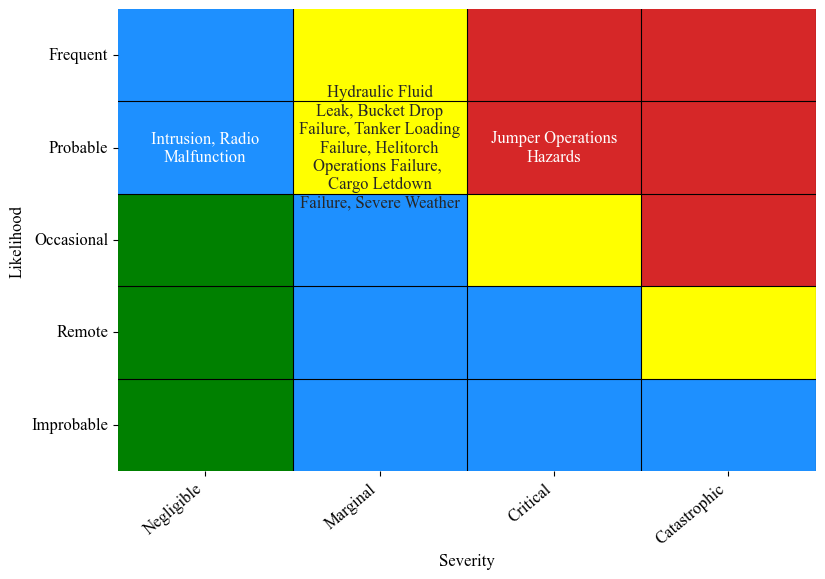

In [51]:
plot_USFS_risk_matrix(likelihood, severities_USFS, figsize=(9,6), save=False, results_path="SAFECOM_JAIS_USFS_risk_matrix", fontsize=12, max_chars=24, title=False)

# Situation Specific Risk Matrices

To demonstrate the usefulness of this framework, we present a case study of situation specific risk matrices developed from SAFECOM reports. 

Here we define the functions needed to create these risk matrices. They include filtering the dataframe based on a set of conditions, then recalculating the hazard rate and severity for each hazard.

In [52]:
def filter_df(df, filters):
    for col in filters:
        df = df.dropna(subset=[col])
        df = df[df[col].apply(lambda x: filters[col] in x)].reset_index(drop=True)
    return df

In [53]:
def get_custom_rm(df, filters, hazard_file, results_file, keep_hazards=[]):
    preprocessed_df = filter_df(df, filters)
    frequency, docs, hazard_words_per_doc, topics_per_doc, hazard_topics_per_doc = identify_docs_per_hazard(hazard_file, preprocessed_df, results_file, 'Narrative', 'Year', "Tracking #", 'Narrative', doc_topic_dist_field='document topic distribution', topic_thresh=0.2)
    rates = calc_rate(frequency)
    _, severities = calc_severity_per_hazard(docs, preprocessed_df, id_field='Tracking #')
    #replace nans with 0
    severities = {hazard:severities[hazard] if (not np.isnan(severities[hazard])) else 0 for hazard in severities}
    if keep_hazards == []: keep_hazards = [hazard for hazard in docs]
    #rm extra hazards
    severities = {hazard: severities[hazard] for hazard in severities if hazard in keep_hazards}
    rates = {hazard: rates[hazard] for hazard in rates if hazard in keep_hazards}
    severities_USFS = get_SAFECOM_severity_USFS(severities)
    likelihood = get_likelihood_USFS(rates)
    plot_USFS_risk_matrix(likelihood, severities_USFS, figsize=(9,7), save=False, results_path="", fontsize=10, max_chars=30, title=False)

### Example 1: Aerial commander flying an Aero Commander airplane in California

We define the hazards to include on the custom risk matrix:

In [54]:
keep_hazards = ['Hydraulic Fluid Leak','Intrusion','Bucket Drop Failure','Radio Malfunction','Jumper Operations Hazards',
                'Tanker Loading Failure','Helitorch Operations Failure', 'Cargo Letdown Failure','Severe Weather',
               'Fuel System Malfunction', 'Landing Gear Malfunction', 'Engine Malfunction', 'Oil Malfunction', 'Control Surface Damage',
               'In-flight Collision', 'Door Failure']

Next we specify the featues that define the scenario and get the custom risk matrix:

100%|██████████| 28/28 [00:01<00:00, 20.31it/s]
c:\Users\srandrad\Anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
c:\Users\srandrad\Anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


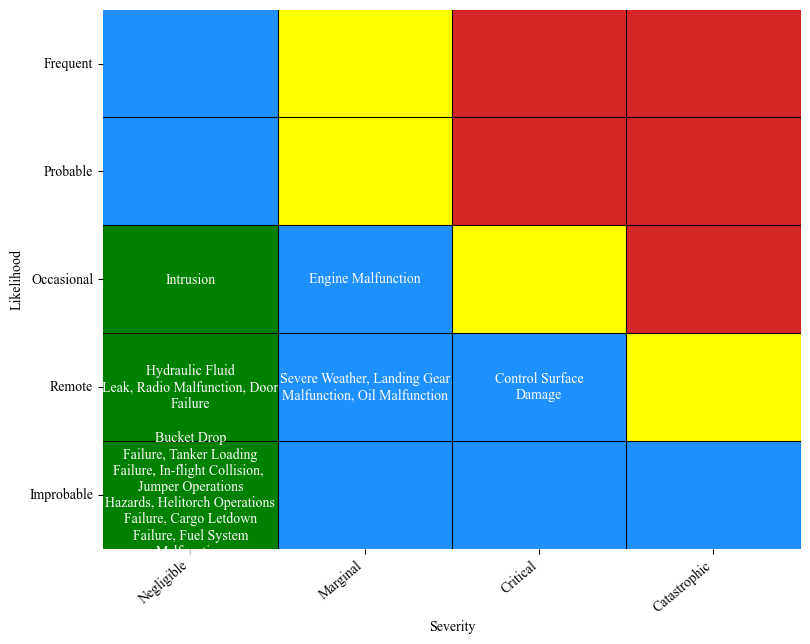

In [55]:
filters ={"Mission Type":'Fire, Air Attack',
          "Type":'Airplane',
         "Manufacturer":'Aero Commander',
         "region_corrected":'Region 05 Pacific Southwest Region'}
get_custom_rm(preprocessed_df, filters, hazard_file, results_file, keep_hazards)

### Example 2: Air Tanker flying a redardant drop mission with a Lockheed multi-engine in Oregon

Again, specify the filters that define the scenario then get the risk matrix:

100%|██████████| 28/28 [00:00<00:00, 35.98it/s]


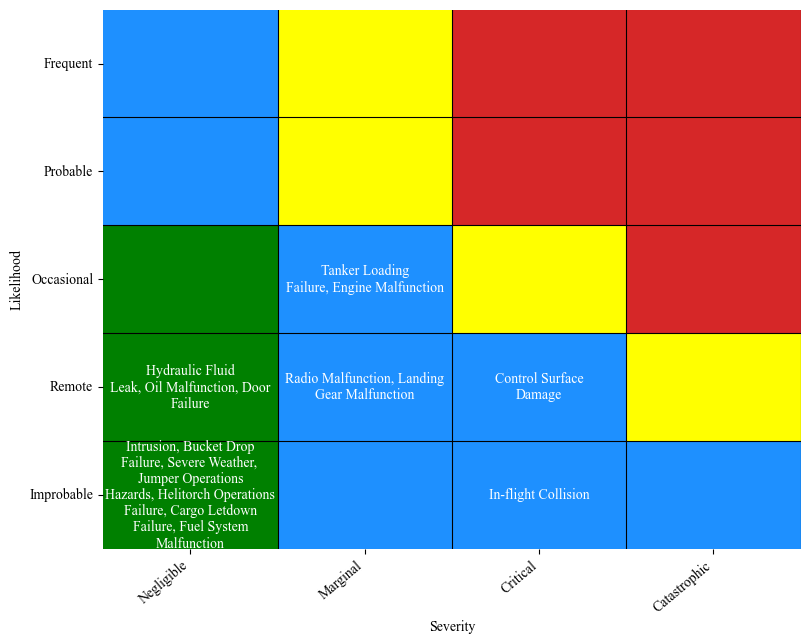

In [56]:
filters ={"Mission Type":'Fire, Retardant Drop (Airtanker)',
         "Type":'Airtanker (Multi-Engine)',
          "Manufacturer": "Lockheed",
         'region_corrected':'Region 06 Pacific Northwest Region'}
get_custom_rm(preprocessed_df, filters, hazard_file, results_file, keep_hazards)

### Example 3: Pilot flying a Bell Helicopter for reconnaisance in Texas

In addition to specifying the filters, for this risk matrix we also define a new list of hazards that are more relevant to this scenario:

100%|██████████| 28/28 [00:00<00:00, 40.61it/s]


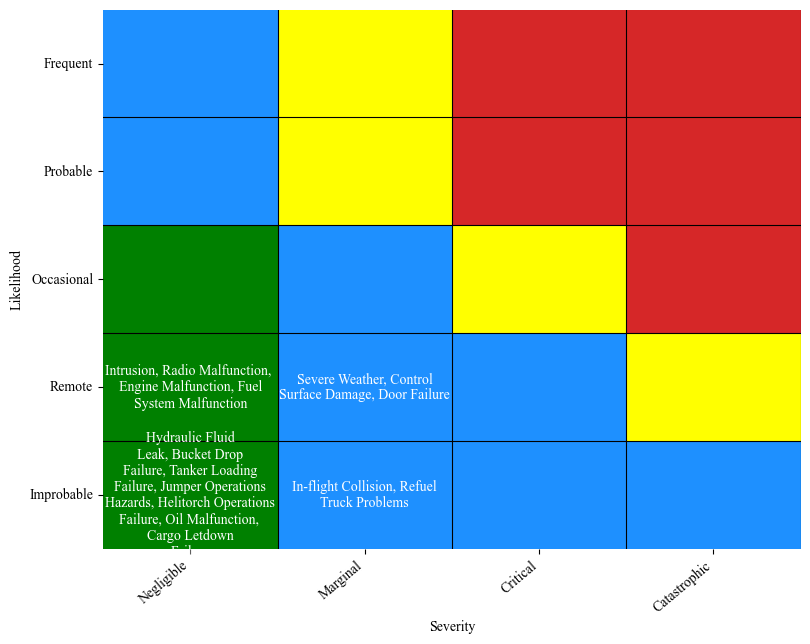

In [57]:
filters ={"Mission Type":'Fire, Reconnaissance',
         "Type":'Helicopter',
          "Manufacturer": "Bell",
          #"Model":"600",#includes 600
          'region_corrected':'Region 08 Southern Area Region'}
keep_hazards = ['Hydraulic Fluid Leak','Intrusion','Bucket Drop Failure','Radio Malfunction','Jumper Operations Hazards',
                'Tanker Loading Failure','Helitorch Operations Failure', 'Cargo Letdown Failure','Severe Weather',
               'Fuel System Malfunction', 'Engine Malfunction', 'Oil Malfunction', 'Control Surface Damage',
               'In-flight Collision', 'Door Failure', 'Refuel Truck Problems']
get_custom_rm(preprocessed_df, filters, hazard_file, results_file, keep_hazards)